<a href="https://colab.research.google.com/github/BlueBerry-Coder/Practice/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pylab as plt
import pydicom as dicom
import nibabel as nib
from PIL import Image
from glob import glob
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import rotate

In [ ]:
# Training Data,
      #t1-исходные, t1ce-постконтрастные взвешенные, t2-взвешенные, flair-с подавленной инверсией восстановлением жидкости, seg-сегментированные
      #path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'

# Validation Data
      #t1-исходные, t1ce-постконтрастные взвешенные, t2-взвешенные, flair-с подавленной инверсией восстановлением жидкости
      #path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_t1.nii'

In [ ]:
root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

class BratsDataset(Dataset):
    def __init__(self, train_img_dir, train_mask_dir, transform=None):
        self.train_img_dir = train_t1_dir
        self.train_mask_dir = train_mask_dir
        self.transform = transform
        self.images = os.listdir(train_t1_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.train_t1_dir, self.images[index])
        mask_path = os.path.join(self.train_mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

class BratsDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.researchs_dir = [os.path.join(root_dir, p) for p in os.listdir(root_dir)]
        self.check_files = ["flair.nii", "t1.nii", "t1ce.nii", "t2.nii", "seg.nii"]
        self.check_researchs()
        self.transform = transforms
        self.mask_labels = [1.0, 2.0, 4.0]

    def check_researchs(self):
        for dir in self.researchs_dir:
            for f in self.check_files:
                file_endings = [pth.split('_')[-1] for pth in os.listdir(dir)]
                if f not in file_endings:
                    print(f"In research {dir} no file with {f} ending.")

    def __len__(self):
        return len(self.researchs_dir)

    def __getitem__(self, index):
        flair_path = os.path.join(self.researchs_dir[index], self.researchs_dir[index].split("\\")[-1]) + "_flair.nii"
        t1_path = os.path.join(self.researchs_dir[index], self.researchs_dir[index].split("\\")[-1]) + "_t1.nii"
        t1ce_path = os.path.join(self.researchs_dir[index], self.researchs_dir[index].split("\\")[-1]) + "_t1ce.nii"
        t2_path = os.path.join(self.researchs_dir[index], self.researchs_dir[index].split("\\")[-1]) + "_t2.nii"
        mask_path = os.path.join(self.researchs_dir[index], self.researchs_dir[index].split("\\")[-1]) + "_seg.nii"
        flair = self.normalize(np.expand_dims(np.asarray(nib.load(flair_path).dataobj), -1))
        t1 = self.normalize(np.expand_dims(np.asarray(nib.load(t1_path).dataobj), -1))
        t1ce = self.normalize(np.expand_dims(np.asarray(nib.load(t1ce_path).dataobj), -1))
        t2 = self.normalize(np.expand_dims(np.asarray(nib.load(t2_path).dataobj), -1))
        mask_data = np.asarray(nib.load(mask_path).dataobj)

        mask = np.concatenate([np.expand_dims(mask_data == label, -1).astype(np.float32) for label in self.mask_labels], axis=-1)
        research_data = np.concatenate((flair, t1, t1ce, t2), axis=3)

        if self.transform is not None:
            augmentations = self.transform(image=research_data, mask=mask)
            research_data = augmentations["image"]
            mask = augmentations["mask"]

        return research_data, mask

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)

    def plot_example(self, index, n=7, slices=10):
        research_data, mask = self.__getitem__(index)

        plt.style.use('default')
        fig, axes = plt.subplots(n, slices, figsize=(20, 20))
        step = len(axes.reshape(-1)) // n
        for i, ax in enumerate(axes.reshape(-1)):
            if i < step:
                ax.imshow(research_data[:, :, 1 + (research_data.shape[2] // slices) * (i % slices), 0])
            elif i < 2 * step:
                ax.imshow(research_data[:, :, 1 + (research_data.shape[2] // slices) * (i % slices), 1])
            elif i < 3 * step:
                ax.imshow(research_data[:, :, 1 + (research_data.shape[2] // slices) * (i % slices), 2])
            elif i < 4 * step:
                ax.imshow(research_data[:, :, 1 + (research_data.shape[2] // slices) * (i % slices), 3])
            elif i < 5 * step:
                ax.imshow(mask[:, :, 1 + (mask.shape[2] // slices) * (i % slices), 0])
            elif i < 6 * step:
                ax.imshow(mask[:, :, 1 + (mask.shape[2] // slices) * (i % slices), 1])
            else:
                ax.imshow(mask[:, :, 1 + (mask.shape[2] // slices) * (i % slices), 2])
        plt.show()

In [ ]:
if __name__ == "__main__":
    d = BratsDataset(r"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")
    d.__getitem__(10)
    d.plot_example(10, slices=10)
    from volumentations import Compose, Rotate, RandomCrop, Normalize

    transforms = Compose([
        Rotate((-30, 30), (-30, 30), (-30, 30), p=1.0),
        RandomCrop((128, 128, 128), p=1.0),
        # Normalize()
    ]
    )

    d = BratsDataset(r"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData", transforms=transforms)
    d.__getitem__(10)
    d.plot_example(10, slices=10)

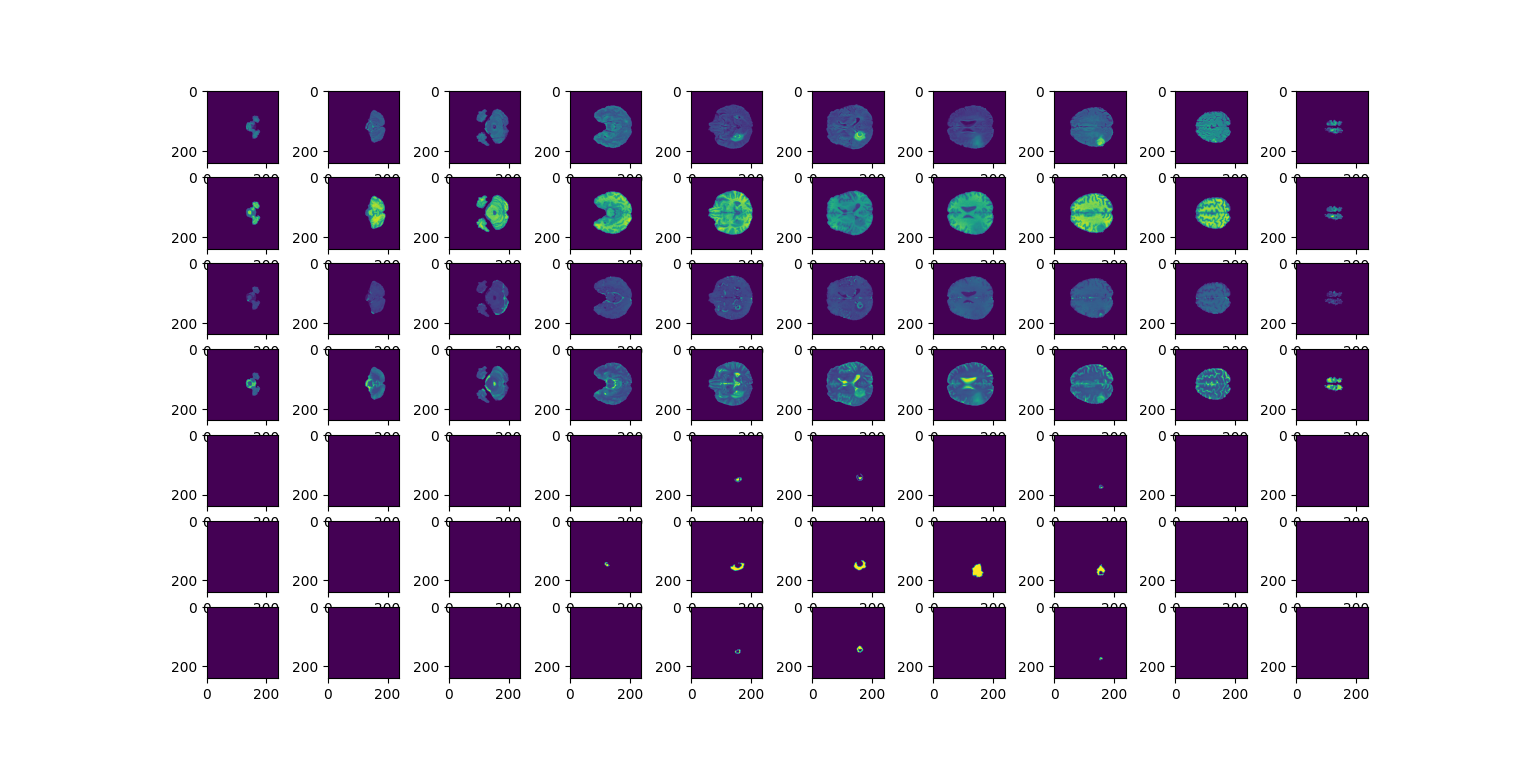

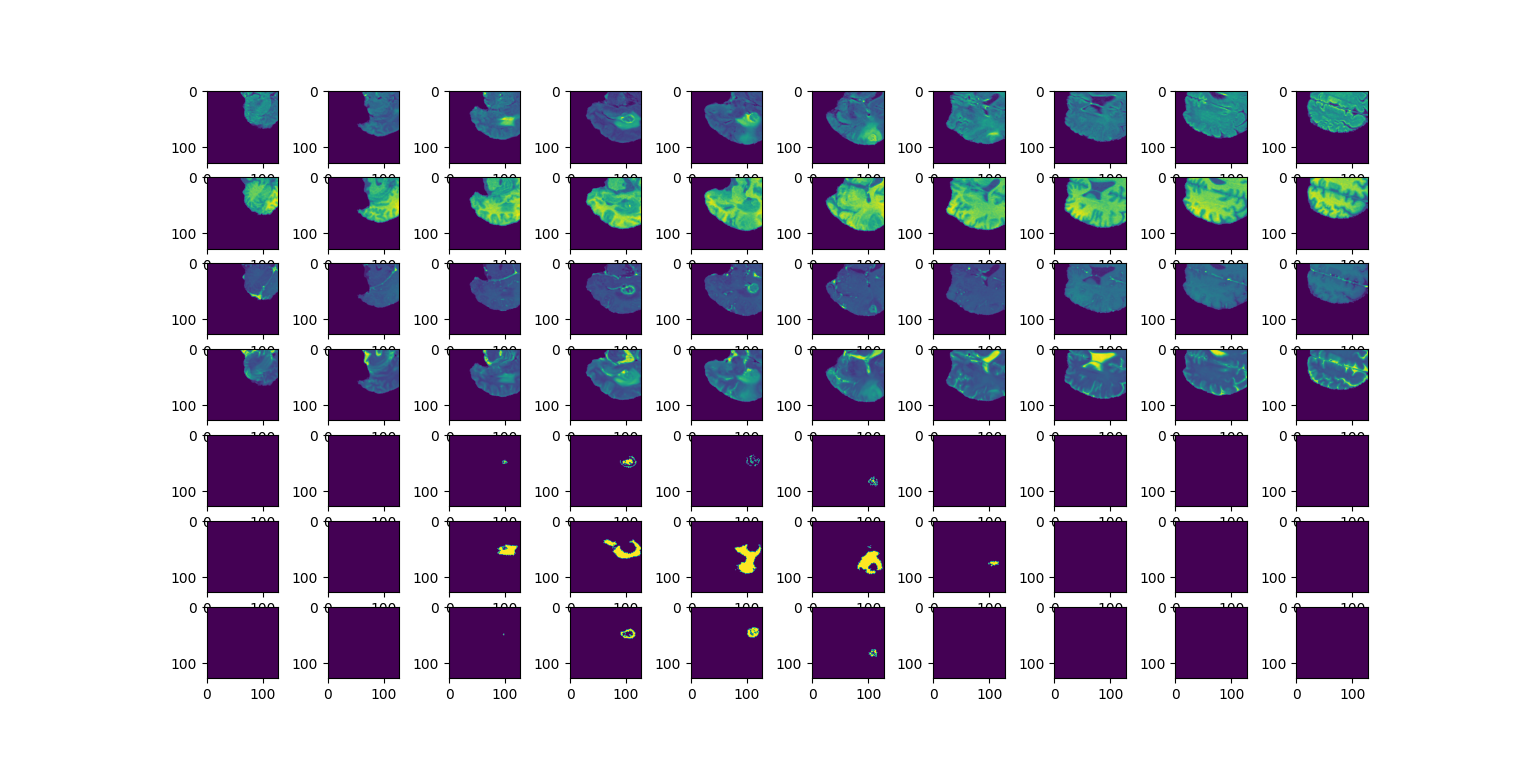